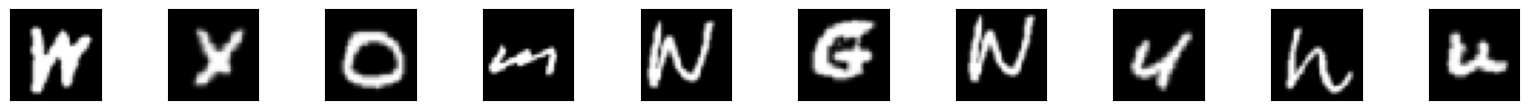

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaded_images = utils.load_images_from_zip()
emnist_data, emnist_labels = utils.load_true_emnist()

emnist_data = emnist_data.astype(np.float32)
loaded_images = loaded_images.astype(np.float32)

utils.plot_images(loaded_images[10:20])

In [101]:
loaded_images.shape

(131057, 32, 32)

In [102]:
emnist_data.shape

(112799, 28, 28)

## 1. Resize EMNIST to 32 by 32

In [103]:
import cv2

In [104]:
emnist_data_resized = np.array([cv2.resize(img, (32, 32), interpolation=cv2.INTER_LINEAR) for img in emnist_data])

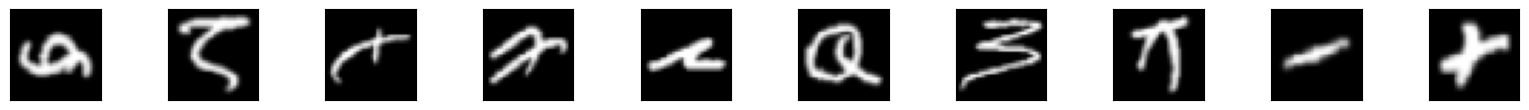

In [105]:
# Let us have a look at the resized images
utils.plot_images(emnist_data_resized[:10])

Doesn't seem like we lost too much granularity (considering the images weren't pretty to begin with, no judgment).

## 2. Train VAE on EMNIST

VAE architecture from [here](https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb)

In [106]:
# Import VAE architecture and utils
from vae import VAE, loss_function, train, test

In [107]:
class EMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [108]:
# Load EMNIST into data loaders for pytorch
transform = transforms.Compose([
    transforms.ToTensor(),
])

#### Train-Test split

In [109]:
emnist_data_train, emnist_data_test, emnist_labels_train, emnist_labels_test = train_test_split(emnist_data_resized, emnist_labels, test_size=0.2, random_state=42)

In [110]:
batch_size = 100

emnist_train = EMNISTDataset(data=emnist_data_train, labels=emnist_labels_train, transform=transform)
emnist_train_loader = DataLoader(dataset=emnist_train, batch_size=batch_size, shuffle=True)

emnist_test = EMNISTDataset(data=emnist_data_test, labels=emnist_labels_test, transform=transform)
emnist_test_loader = DataLoader(dataset=emnist_test, batch_size=batch_size, shuffle=True)

#### VAE loading and init

In [111]:
# Build model
vae = VAE(x_dim=1024, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [112]:
optimizer = optim.Adam(vae.parameters())

In [113]:
for epoch in range(1, 51):
    train(vae, optimizer, emnist_train_loader, epoch)
    test(vae, emnist_test_loader)

Train Epoch: 1 [0/90239 (0%)]	Loss: 710.756406
Train Epoch: 1 [10000/90239 (11%)]	Loss: 341.588672
Train Epoch: 1 [20000/90239 (22%)]	Loss: 323.301445
Train Epoch: 1 [30000/90239 (33%)]	Loss: 325.505117
Train Epoch: 1 [40000/90239 (44%)]	Loss: 326.189277
Train Epoch: 1 [50000/90239 (55%)]	Loss: 319.459902
Train Epoch: 1 [60000/90239 (66%)]	Loss: 310.883809
Train Epoch: 1 [70000/90239 (78%)]	Loss: 317.008535
Train Epoch: 1 [80000/90239 (89%)]	Loss: 308.624375
Train Epoch: 1 [90000/90239 (100%)]	Loss: 309.603848
====> Epoch: 1 Average loss: 324.4591
====> Test set loss: 310.3148
Train Epoch: 2 [0/90239 (0%)]	Loss: 302.233437
Train Epoch: 2 [10000/90239 (11%)]	Loss: 316.445918
Train Epoch: 2 [20000/90239 (22%)]	Loss: 304.329941
Train Epoch: 2 [30000/90239 (33%)]	Loss: 298.183691
Train Epoch: 2 [40000/90239 (44%)]	Loss: 319.201621
Train Epoch: 2 [50000/90239 (55%)]	Loss: 306.375098
Train Epoch: 2 [60000/90239 (66%)]	Loss: 303.078555
Train Epoch: 2 [70000/90239 (78%)]	Loss: 298.486250
Train

#### Visualize some randomly generated images

In [114]:
from torchvision.utils import save_image

In [115]:
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z)
    
    save_image(sample.view(64, 1, 32, 32), './samples/sample_' + '.png')

#### Plot reconstruction loss for some images in the noisy EMNIST dataset

In [116]:
import torch.nn.functional as F

In [117]:
def loss_function_per_x(recon_x, x, mu, log_var):
    BCE = torch.mean(F.binary_cross_entropy(recon_x, x.view(-1, 1024), reduction="none"), axis=1)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    return BCE + KLD

In [118]:
def reconstruction_loss_per_x(vae, loader):
    vae.eval()
    loss= []
    with torch.no_grad():
        for data, _ in loader:
            if torch.cuda.is_available():
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            loss += list(loss_function_per_x(recon, data, mu, log_var))
        
    print('====> Reconstruction loss for each x has been calculated!')

    return loss

====> Reconstruction loss for each x has been calculated!
[7.904698371887207, 6.667551040649414, 9.858214378356934, 7.53099250793457, 7.818428993225098, 8.377829551696777, 11.417512893676758, 6.566085338592529, 6.137892723083496, 5.068447113037109, 6.7416768074035645, 6.911409854888916, 7.498992443084717, 6.970281600952148, 6.906190872192383, 7.309037208557129, 7.872317314147949, 6.777218818664551, 6.186948299407959, 6.42244291305542, 8.037245750427246, 7.618420124053955, 7.773838043212891, 7.522268295288086, 8.875163078308105, 6.1524577140808105, 7.284345626831055, 9.125214576721191, 7.9252448081970215, 7.036444664001465, 7.241671562194824, 7.631292819976807, 8.749536514282227, 7.32000732421875, 7.146907329559326, 6.831990718841553, 6.5362701416015625, 7.033504962921143, 7.22824239730835, 7.770083904266357, 9.261905670166016, 7.434144496917725, 8.072273254394531, 7.979520797729492, 7.087698936462402, 7.7035441398620605, 7.434953212738037, 6.94050407409668, 6.9895124435424805, 7.890640

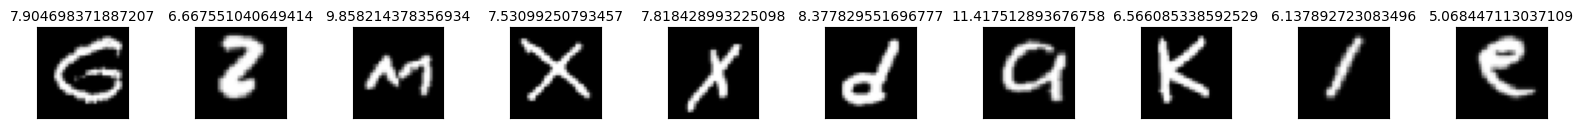

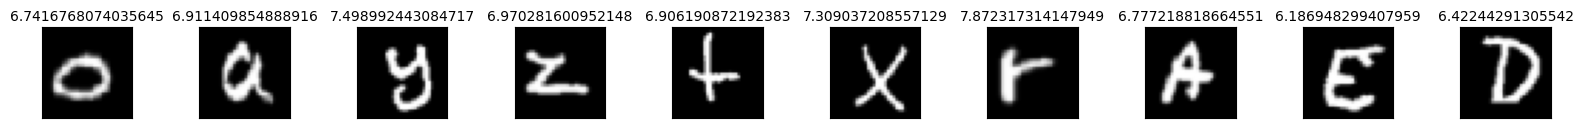

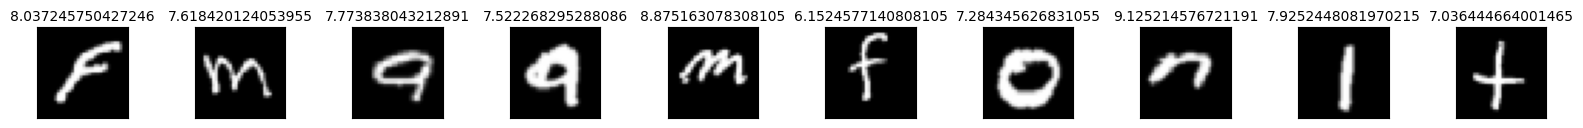

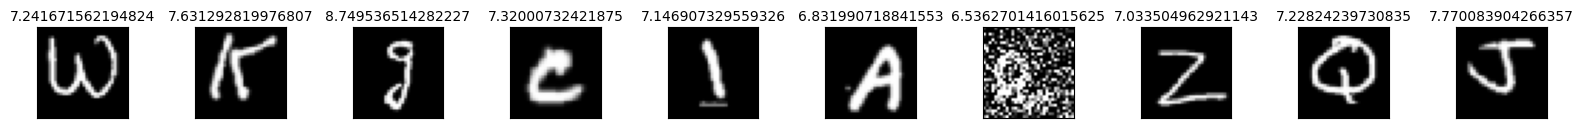

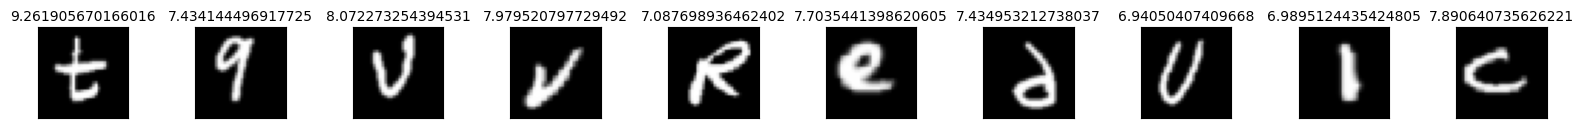

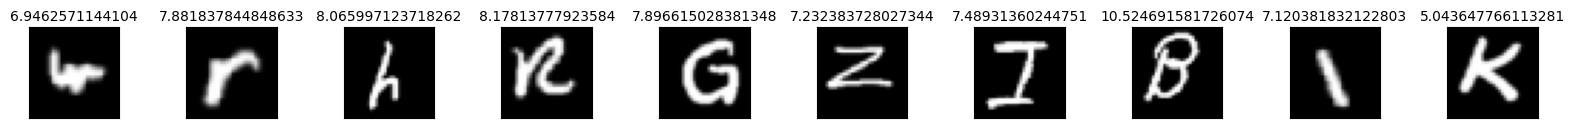

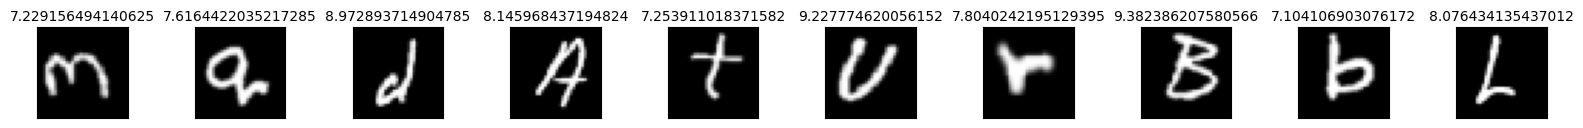

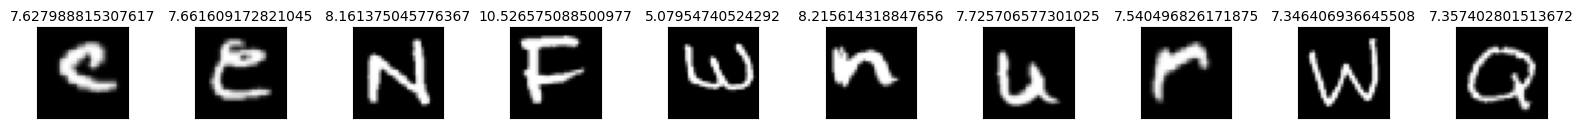

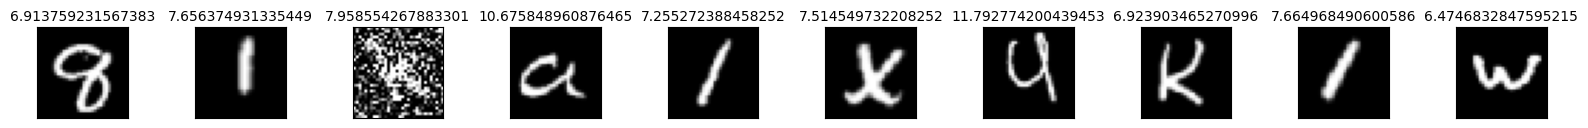

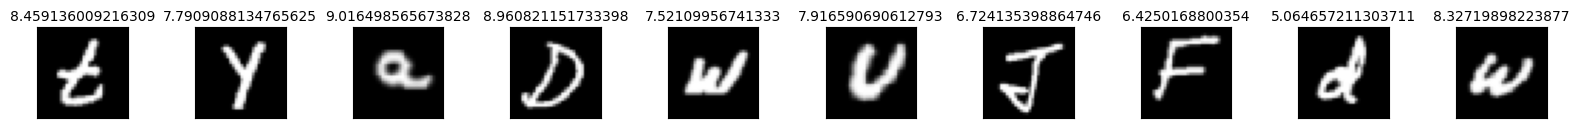

In [130]:
indexes = np.random.choice(len(loaded_images), 100, replace=False)
data = torch.tensor(loaded_images[indexes]).float().to(device)
emnist_noisy = EMNISTDataset(data=loaded_images[indexes], labels=[1 for _ in range(len(loaded_images[indexes]))], transform=transform)
emnist_noisy_loader = DataLoader(dataset=emnist_noisy, batch_size=batch_size, shuffle=True)
loss = [el.item() for el in reconstruction_loss_per_x(vae, emnist_noisy_loader)]
print(loss)
print(len(loss))
utils.plot_images(data, labels=loss)